In [1]:

import polars as pl
import pandas as pd
import datetime as dt
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from glob import glob 

In [12]:
DATA_PATH = r'.\\data\\raw\\traffic\\a_year-has_rain\\*.csv'
SEPARATOR = '|'

In [4]:
# OUTPUT_PATH = './out_stats_31May2023_rain'
# os.makedirs(OUTPUT_PATH, exist_ok=True)

#### Read CSV files

In [13]:
d = []
for csv in glob(DATA_PATH):
    # data = pl.read_csv(source=csv, separator=SEPARATOR, try_parse_dates=True, low_memory=True, infer_schema_length=10_000)
    data = pl.read_csv(source=csv, separator=SEPARATOR, try_parse_dates=True, infer_schema_length=10000)
    if 'rain' in data.columns: data = data.with_columns(pl.col('rain').cast(pl.Float64))
    d.append(data)
df = pl.concat(d)

In [14]:
df.shape

(252820578, 5)

In [16]:
df.head()

date,time_id,kml_segment_id,speed,rain
datetime[μs],i64,i64,f64,f64
2022-01-01 00:00:00,14,7381,23.1,0.0
2022-01-01 00:00:00,15,3776,8.83,0.0
2022-01-01 00:00:00,16,7283,39.5,0.0
2022-01-01 00:00:00,18,9131,16.67,0.0
2022-01-01 00:00:00,20,5592,3.22,0.0


#### Check and process null value, duplicated samples

In [17]:
print(df.null_count())
print('#'*10)
df = df.drop_nulls()
df.null_count()

shape: (1, 5)
┌──────┬─────────┬────────────────┬───────┬────────┐
│ date ┆ time_id ┆ kml_segment_id ┆ speed ┆ rain   │
│ ---  ┆ ---     ┆ ---            ┆ ---   ┆ ---    │
│ u32  ┆ u32     ┆ u32            ┆ u32   ┆ u32    │
╞══════╪═════════╪════════════════╪═══════╪════════╡
│ 0    ┆ 103429  ┆ 0              ┆ 0     ┆ 103429 │
└──────┴─────────┴────────────────┴───────┴────────┘
##########


date,time_id,kml_segment_id,speed,rain
u32,u32,u32,u32,u32
0,0,0,0,0


In [1]:
duplicated_samples = df.filter(df.is_duplicated()).sort(by=['kml_segment_id', 'date', 'time_id'])
# duplicated_samples.write_csv(os.path.join(OUTPUT_PATH, 'duplicate_records.csv'))
duplicated_samples.shape

NameError: name 'df' is not defined

In [13]:
df = df.unique()
df = df.unique(['kml_segment_id', 'date', 'time_id'])
df.filter(df.is_duplicated()).sort(by=['kml_segment_id', 'date', 'time_id'])

date,time_id,kml_segment_id,speed,rain
datetime[μs],i64,i64,f64,f64


#### Format datetime 

In [14]:
df['date'][0]

datetime.datetime(2022, 7, 20, 0, 0)

In [15]:
df = df.with_columns(
    pl.col("date").str.strptime(pl.Date, fmt="%Y-%m-%d %H:%M:%S"))
df.head()

SchemaError: invalid series dtype: expected `Utf8`, got `datetime[μs]`

#### Check missing days

In [ ]:
date_count_df = df.groupby('date').agg(pl.count()).sort(by='date')
date_count_df

date,count
date,u32
2022-01-01,447192
2022-01-02,468365
2022-01-03,485375
2022-01-04,492849
2022-01-05,497399
2022-01-06,494143
2022-01-07,478278
2022-01-08,493341
2022-01-09,487608


In [ ]:
one_year_datetime = pd.DataFrame({ 'date' : pd.date_range("2022-01-01", "2022-12-31", freq="1D"),
  'count' : np.full(shape=365, fill_value=np.nan)
 
})
one_year_datetime

,date,count
0,2022-01-01,NaN
1,2022-01-02,NaN
2,2022-01-03,NaN
3,2022-01-04,NaN
4,2022-01-05,NaN
...,...,...
360,2022-12-27,NaN
361,2022-12-28,NaN
362,2022-12-29,NaN
363,2022-12-30,NaN


In [ ]:
date_count_pd_df = date_count_df.to_pandas()
date_count_pd_df = one_year_datetime.merge(date_count_pd_df, how='left', on='date').drop(columns='count_x').rename(columns={'count_y':'count'})

In [ ]:
date_count_df = pl.from_pandas(date_count_pd_df)

print('Count missing days')
print(date_count_df.null_count())

print('Missing days')
date_count_df.filter(
    pl.col('count').is_null()
)

Count missing days
shape: (1, 2)
┌──────┬───────┐
│ date ┆ count │
│ ---  ┆ ---   │
│ u32  ┆ u32   │
╞══════╪═══════╡
│ 0    ┆ 1     │
└──────┴───────┘
Missing days


date,count
datetime[ns],f64
2022-02-03 00:00:00,null


#### Describe speed by ID

In [ ]:
print('Total IDs')
print(df['kml_segment_id'].unique().shape)

Total IDs
(9661,)


In [16]:
group_describe_pd = df.to_pandas().groupby('kml_segment_id')['rain'].describe()
group_describe_pd.reset_index(inplace=True)
group_describe_pd

,kml_segment_id,count,mean,std,min,25%,50%,75%,max
0,1,39146.0,0.224799,1.929014,0.0,0.0,0.0,0.0,56.6
1,2,20692.0,0.298231,2.348860,0.0,0.0,0.0,0.0,76.8
2,3,63014.0,0.256308,1.905301,0.0,0.0,0.0,0.0,44.0
3,4,12637.0,0.386658,2.833429,0.0,0.0,0.0,0.0,76.8
4,5,37065.0,0.284328,2.298124,0.0,0.0,0.0,0.0,76.8
...,...,...,...,...,...,...,...,...,...
9656,9752,22182.0,0.258759,1.924798,0.0,0.0,0.0,0.0,44.0
9657,9753,28724.0,0.277064,1.914367,0.0,0.0,0.0,0.0,44.0
9658,9754,56893.0,0.283082,2.002335,0.0,0.0,0.0,0.0,44.0
9659,9755,37261.0,0.220858,1.928003,0.0,0.0,0.0,0.0,56.6


In [17]:
group_describe_pl = pl.from_pandas(group_describe_pd)
group_describe_pl = group_describe_pl.sort(by='count', descending=True)
group_describe_pl.write_csv(os.path.join(OUTPUT_PATH, 'ID_statistics.csv'))
group_describe_pl

kml_segment_id,count,mean,std,min,25%,50%,75%,max
i64,f64,f64,f64,f64,f64,f64,f64,f64
9561,78027.0,0.226314,1.942191,0.0,0.0,0.0,0.0,60.4
3576,74500.0,0.246556,1.859802,0.0,0.0,0.0,0.0,44.0
8921,73713.0,0.255415,1.888176,0.0,0.0,0.0,0.0,44.0
4453,73130.0,0.233417,1.986366,0.0,0.0,0.0,0.0,60.4
7961,71995.0,0.243906,1.885538,0.0,0.0,0.0,0.0,43.4
9006,71600.0,0.245422,1.885965,0.0,0.0,0.0,0.0,43.4
8085,71249.0,0.285761,2.318276,0.0,0.0,0.0,0.0,76.8
5592,70943.0,0.238293,2.007836,0.0,0.0,0.0,0.0,60.4
4149,70919.0,0.265196,1.919112,0.0,0.0,0.0,0.0,44.0


In [ ]:
!pwd

/Khoa/Khoa_traffic/365_kml_segment_id/code


In [21]:
group_describe_pl.sort(by=['kml_segment_id', 'count'], descending=True).write_csv(os.path.join(OUTPUT_PATH, '100_ID_count.csv'))

In [22]:
group_describe_pl.sort(by=['count','kml_segment_id'], descending=True).write_csv('100_count_ID.csv')

##### Filter speed > 80

In [23]:
df.filter(
    pl.col('speed') > 80
).shape

(2278, 5)

In [24]:
group_describe_pl.filter(
    pl.col('mean') >= 60
)

kml_segment_id,count,mean,std,min,25%,50%,75%,max
i64,f64,f64,f64,f64,f64,f64,f64,f64


In [25]:
group_describe_pl.filter(
    pl.col('count') <= 5
)

kml_segment_id,count,mean,std,min,25%,50%,75%,max
i64,f64,f64,f64,f64,f64,f64,f64,f64
1631,5.0,3.84,8.586501,0.0,0.0,0.0,0.0,19.2
1688,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3666,5.0,0.04,0.089443,0.0,0.0,0.0,0.0,0.2
5143,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5922,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7842,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1632,4.0,9.6,11.085125,0.0,0.0,9.6,19.2,19.2
2374,4.0,4.8,9.6,0.0,0.0,0.0,4.8,19.2
3253,4.0,4.8,9.6,0.0,0.0,0.0,4.8,19.2


In [26]:
group_describe_pl['mean'].describe()

statistic,value
str,f64
"""min""",0.0
"""max""",9.6
"""null_count""",0.0
"""mean""",0.272094
"""std""",0.152209
"""count""",9661.0


In [27]:
group_describe_pl['std'].describe()

statistic,value
str,f64
"""min""",0.0
"""max""",11.085125
"""null_count""",18.0
"""mean""",2.045992
"""std""",0.401361
"""count""",9661.0


In [28]:
group_describe_pl['max'].describe()

statistic,value
str,f64
"""min""",0.0
"""max""",76.8
"""null_count""",0.0
"""mean""",52.693531
"""std""",15.371679
"""count""",9661.0


In [29]:
group_describe_pl['min'].describe()

statistic,value
str,f64
"""min""",0.0
"""max""",1.2
"""null_count""",0.0
"""mean""",0.000124
"""std""",0.012209
"""count""",9661.0


#### EDA Data

#### Descriptive statistics Day of Week every hours from 04h00 to 22h00m

##### Group by 1hour

In [30]:
def make_hour_dictionary():
    hour_dictionary = {}
    for k in range(1,217):
        div = k//12
        if k%12 != 0:
          hour_dictionary[k] = div + 1
        else:
          hour_dictionary[k] = int(k/12)
    return hour_dictionary

In [31]:
hour_dictionary = make_hour_dictionary()
hour_dictionary

{1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 2,
 23: 2,
 24: 2,
 25: 3,
 26: 3,
 27: 3,
 28: 3,
 29: 3,
 30: 3,
 31: 3,
 32: 3,
 33: 3,
 34: 3,
 35: 3,
 36: 3,
 37: 4,
 38: 4,
 39: 4,
 40: 4,
 41: 4,
 42: 4,
 43: 4,
 44: 4,
 45: 4,
 46: 4,
 47: 4,
 48: 4,
 49: 5,
 50: 5,
 51: 5,
 52: 5,
 53: 5,
 54: 5,
 55: 5,
 56: 5,
 57: 5,
 58: 5,
 59: 5,
 60: 5,
 61: 6,
 62: 6,
 63: 6,
 64: 6,
 65: 6,
 66: 6,
 67: 6,
 68: 6,
 69: 6,
 70: 6,
 71: 6,
 72: 6,
 73: 7,
 74: 7,
 75: 7,
 76: 7,
 77: 7,
 78: 7,
 79: 7,
 80: 7,
 81: 7,
 82: 7,
 83: 7,
 84: 7,
 85: 8,
 86: 8,
 87: 8,
 88: 8,
 89: 8,
 90: 8,
 91: 8,
 92: 8,
 93: 8,
 94: 8,
 95: 8,
 96: 8,
 97: 9,
 98: 9,
 99: 9,
 100: 9,
 101: 9,
 102: 9,
 103: 9,
 104: 9,
 105: 9,
 106: 9,
 107: 9,
 108: 9,
 109: 10,
 110: 10,
 111: 10,
 112: 10,
 113: 10,
 114: 10,
 115: 10,
 116: 10,
 117: 10,
 118: 10,
 119: 10,
 120: 10,
 121: 11,
 122: 

In [32]:
df = df.with_columns(
    pl.col('time_id').apply(lambda x: hour_dictionary[x]).alias('hour_id')
)
print(df['hour_id'].unique())
df.head()

shape: (18,)
Series: 'hour_id' [i64]
[
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
]


date,time_id,kml_segment_id,speed,rain,hour_id
datetime[μs],i64,i64,f64,f64,i64
2022-07-20 00:00:00,139,5428,7.67,0.6,12
2022-03-21 00:00:00,173,2189,20.6,0.0,15
2022-02-21 00:00:00,182,3022,25.0,0.0,16
2022-11-26 00:00:00,128,3429,23.56,0.0,11
2022-10-09 00:00:00,154,2064,19.5,0.0,13


In [33]:
weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dict = {k:weekday_list[k-1] for k in range(1,8)}

In [34]:
df = df.with_columns(
    pl.col('date').dt.weekday().apply(lambda x: weekday_dict[x]).alias('weekday')
)

In [26]:
# # {0 : ['Quan 1', 'Quan 3', 'Quan 5', 'Quan 10'],
# #                   1 : ['Quan 2', 'Quan 9', 'Quan Thu Duc']}
# for k in [0,1]: 
#     for i in tqdm(range(1,8)):
#         with pd.ExcelWriter(f"./district/ID_district_group_{k}_statistics_weekday_speed.xlsx",  mode="a", engine="openpyxl") as writer:
#             tmp = df.filter(
#                         pl.col('weekday') == weekday_list[i-1]
#                     ).filter(
#                         pl.col('hour_id') == 1
#                     ).filter(
#                         pl.col('district_group') == k
#                     ).groupby('current_geopath_id').agg(pl.col('speed').mean().alias('ave_speed')).sort(by='current_geopath_id')
#             tmp = tmp.to_pandas().merge(right=df['current_geopath_id'].unique().to_pandas(), how='right').sort_values(by='current_geopath_id')   
#             tmp = tmp.rename(columns={'ave_speed':f"{1+3}h00-{1+4}h00"})
            
#             for j in range(2,19):
#                 TMP2 = df.filter(
#                         pl.col('weekday') == weekday_list[i-1]
#                     ).filter(
#                         pl.col('hour_id') == j
#                     ).filter(
#                         pl.col('district_group') == k
#                     ).groupby('current_geopath_id').agg(pl.col('speed').mean().alias('ave_speed')).sort(by='current_geopath_id')
#                 TMP2 = TMP2.to_pandas().merge(right=df['current_geopath_id'].unique().to_pandas(), how='right').sort_values(by='current_geopath_id')   
#                 assert len(tmp) == len(TMP2)
#                 tmp = tmp.merge(TMP2.rename(columns={'ave_speed':f"{j+3}h00-{j+4}h00"}), how='left',  on='current_geopath_id') 
            
#             tmp.to_excel(writer, sheet_name=weekday_dict[i], index=False)
        


##### Average Speed

In [36]:
WEEKDAY_RAIN_PATH = os.path.join(OUTPUT_PATH, 'ID_statistics_weekday_rain.xlsx')

In [37]:
for i in tqdm(range(1,8)):
    if i == 1:
        write_mode = 'w'
    else:
        write_mode = 'a'
    with pd.ExcelWriter(WEEKDAY_RAIN_PATH,  mode=write_mode, engine="openpyxl") as writer:
        tmp = df.filter(
                    pl.col('weekday') == weekday_list[i-1]
                ).filter(
                    pl.col('hour_id') == 1
                ).groupby('kml_segment_id').agg(pl.col('rain').mean().alias('ave_rain')).sort(by='kml_segment_id')
        tmp = tmp.to_pandas().merge(right=df['kml_segment_id'].unique().to_pandas(), how='right').sort_values(by='kml_segment_id')   
        tmp = tmp.rename(columns={'ave_rain':f"{1+3}h00-{1+4}h00"})
        
        for j in range(2,19):
            TMP2 = df.filter(
                    pl.col('weekday') == weekday_list[i-1]
                ).filter(
                    pl.col('hour_id') == j
                ).groupby('kml_segment_id').agg(pl.col('rain').mean().alias('ave_rain')).sort(by='kml_segment_id')
            TMP2 = TMP2.to_pandas().merge(right=df['kml_segment_id'].unique().to_pandas(), how='right').sort_values(by='kml_segment_id')   
            assert len(tmp) == len(TMP2)
            tmp = tmp.merge(TMP2.rename(columns={'ave_rain':f"{j+3}h00-{j+4}h00"}), how='left',  on='kml_segment_id') 
        
        tmp.to_excel(writer, sheet_name=weekday_dict[i], index=False)
    


  0%|          | 0/7 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Monday')

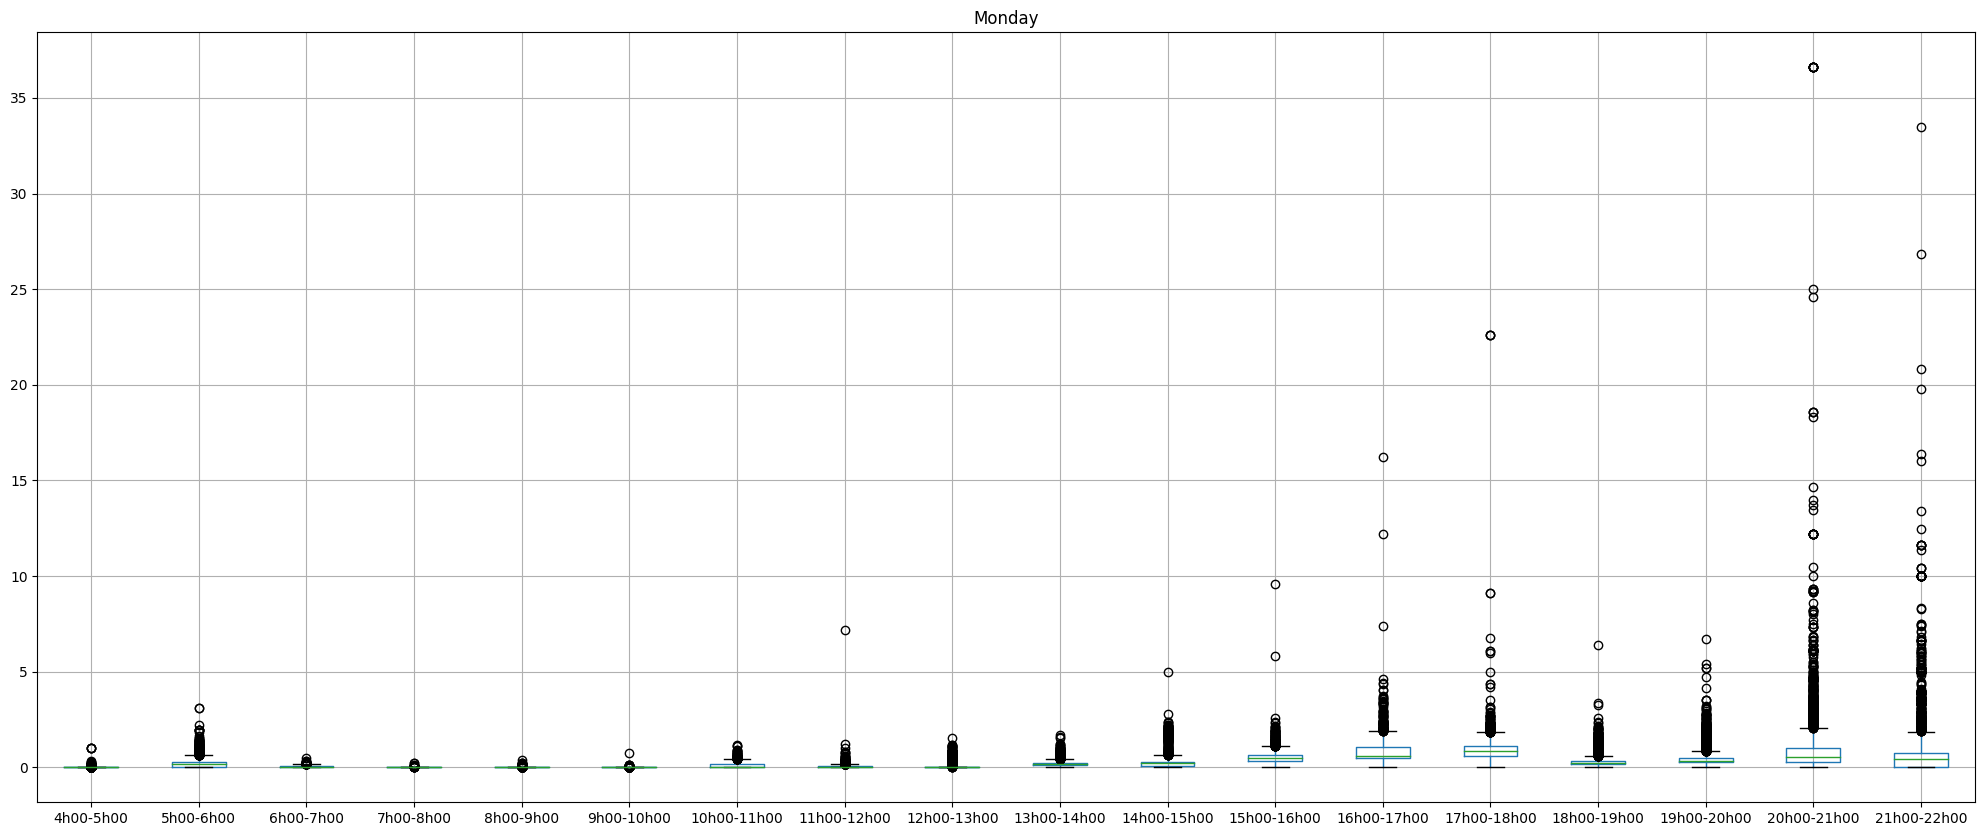

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.read_excel(WEEKDAY_RAIN_PATH, sheet_name=weekday_list[0]).iloc[:,1:].boxplot(figsize=(25,10)).set_title(f'{weekday_list[0]}')

Text(0.5, 1.0, 'Wednesday')

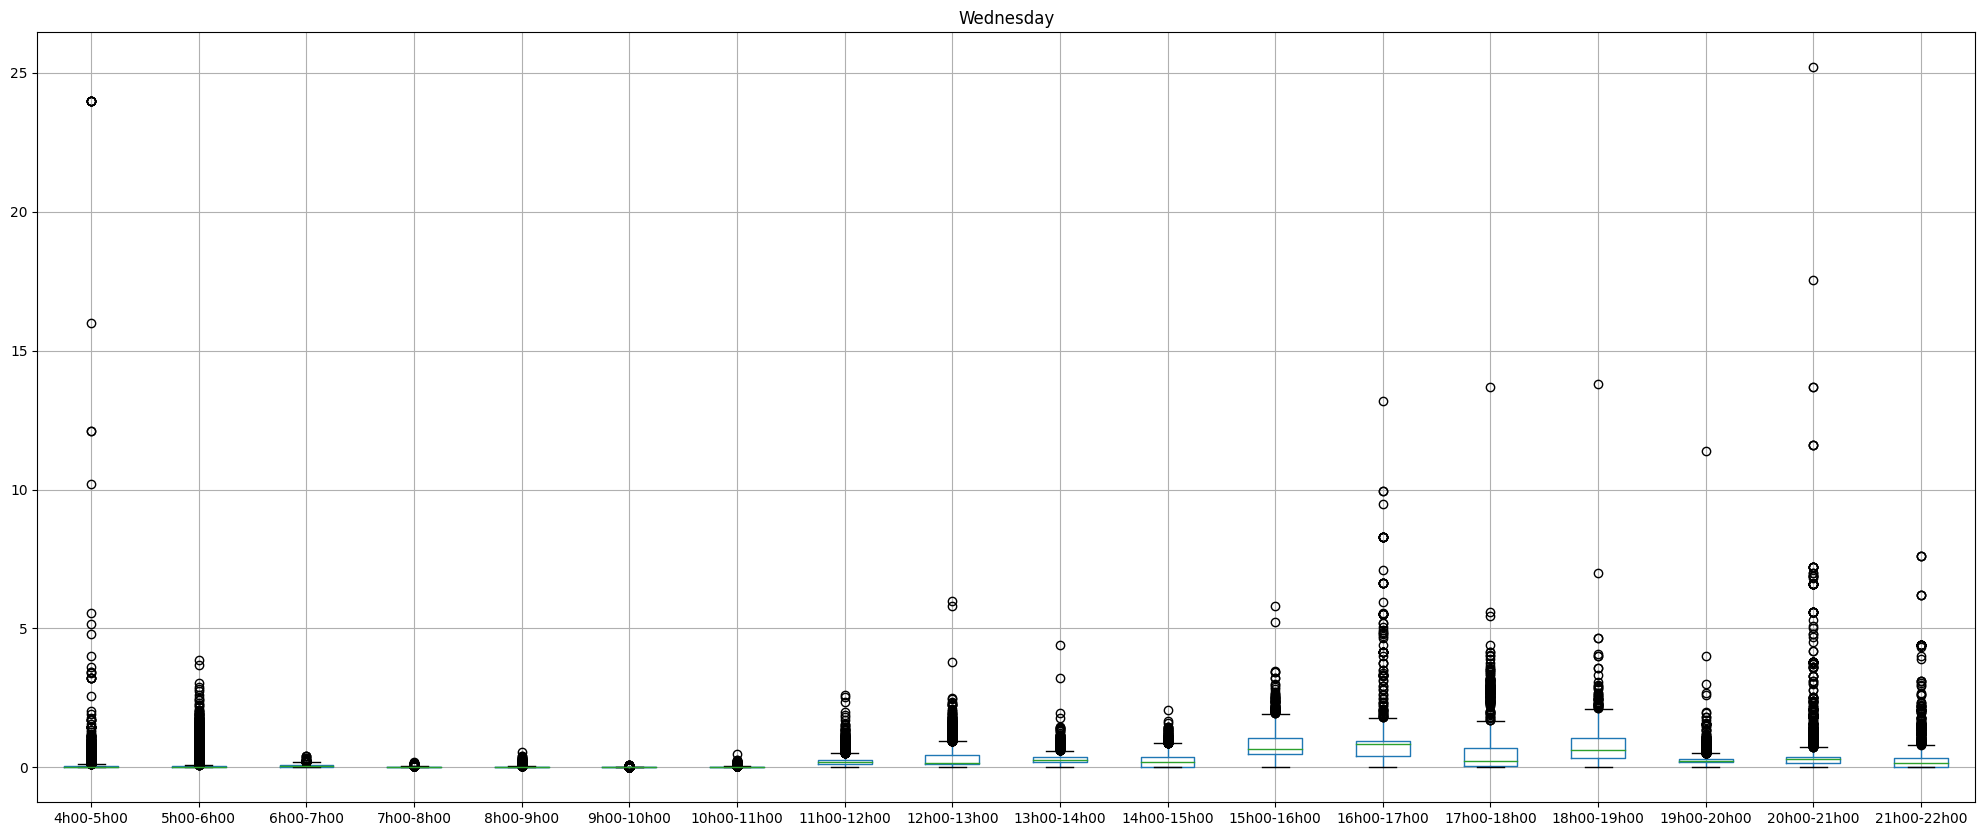

In [40]:
iiiiid = 2
pd.read_excel(WEEKDAY_RAIN_PATH, sheet_name=weekday_list[iiiiid]).iloc[:,1:].boxplot(figsize=(25,10)).set_title(f'{weekday_list[iiiiid]}')


In [30]:
sum([
    pd.read_excel(WEEKDAY_SPEED_PATH, sheet_name=weekday_list[0]).iloc[:,1:].sum().sum(),
    pd.read_excel(WEEKDAY_SPEED_PATH, sheet_name=weekday_list[1]).iloc[:,1:].sum().sum(),
    pd.read_excel(WEEKDAY_SPEED_PATH, sheet_name=weekday_list[2]).iloc[:,1:].sum().sum(),
    pd.read_excel(WEEKDAY_SPEED_PATH, sheet_name=weekday_list[3]).iloc[:,1:].sum().sum(),
    pd.read_excel(WEEKDAY_SPEED_PATH, sheet_name=weekday_list[4]).iloc[:,1:].sum().sum(),
    pd.read_excel(WEEKDAY_SPEED_PATH, sheet_name=weekday_list[5]).iloc[:,1:].sum().sum(),
    pd.read_excel(WEEKDAY_SPEED_PATH, sheet_name=weekday_list[6]).iloc[:,1:].sum().sum()
])

24108483.642456368

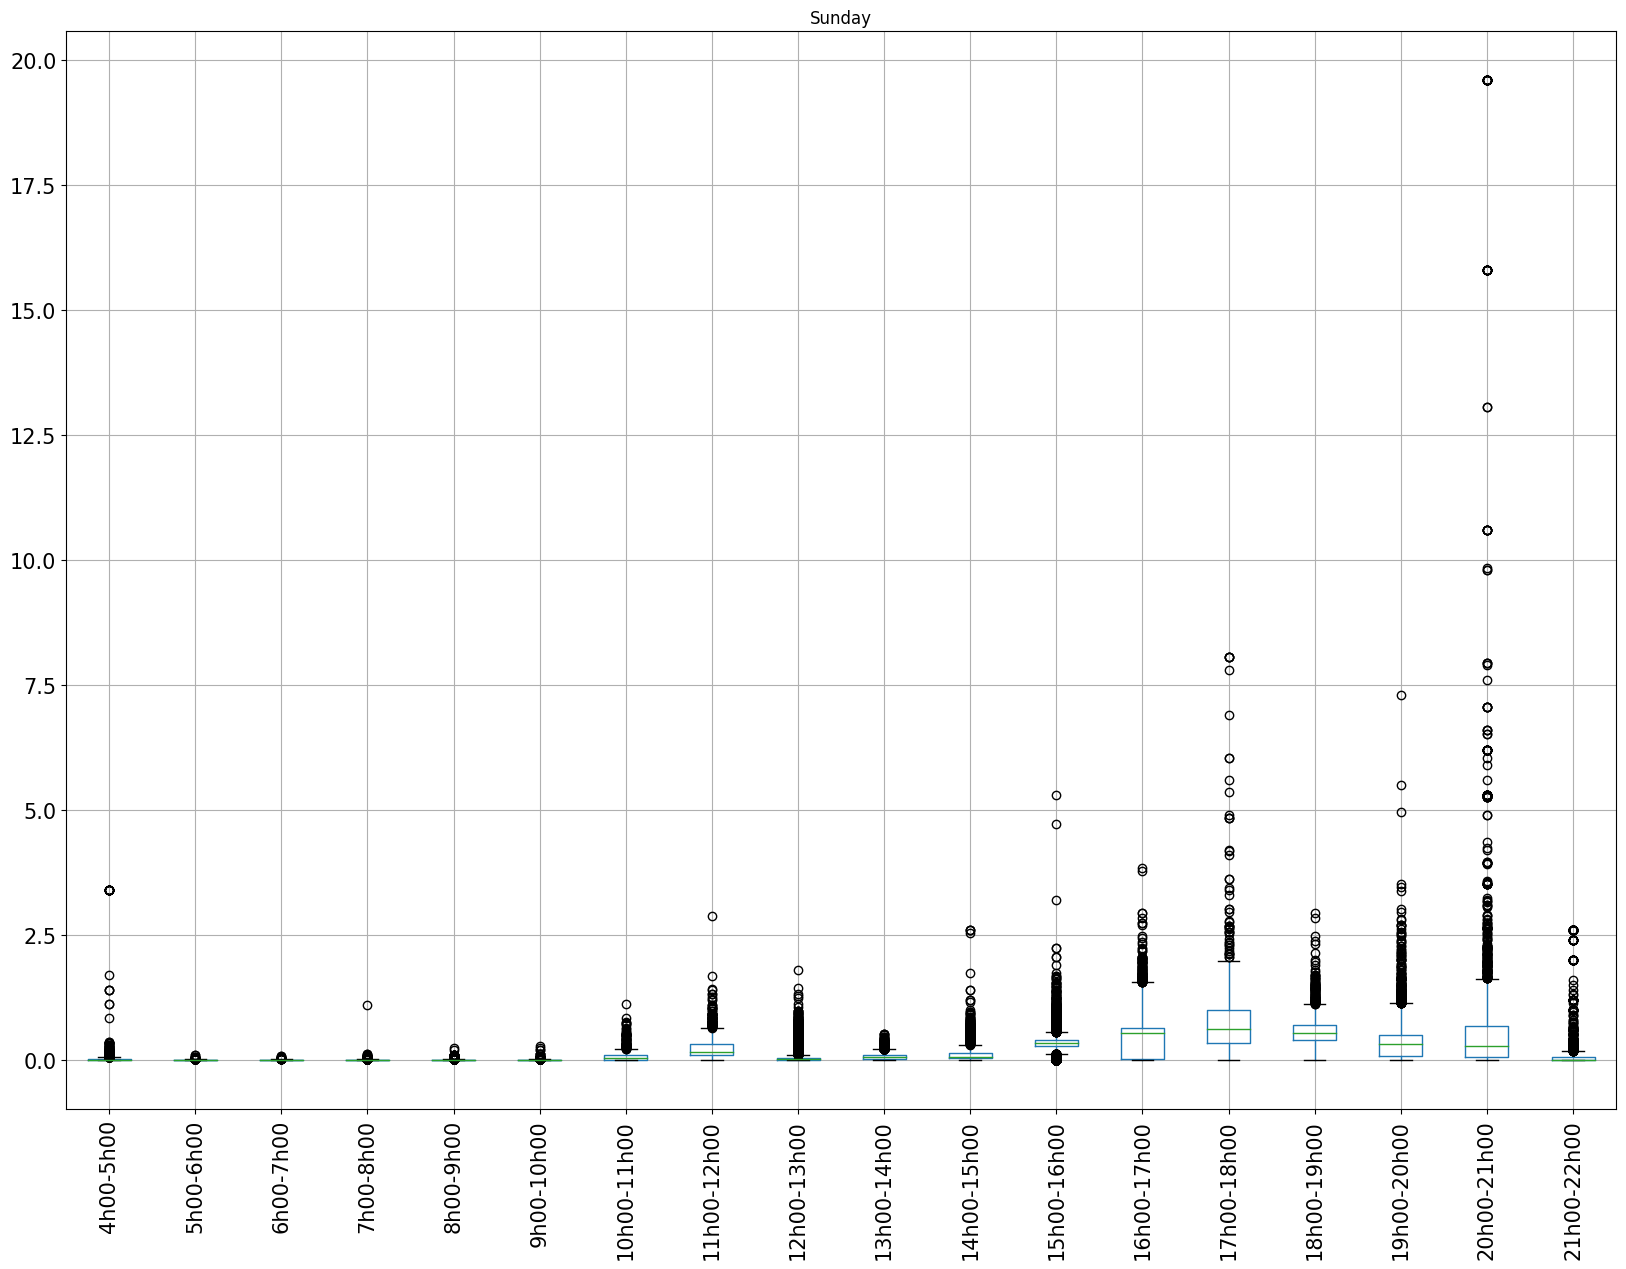

In [42]:
for wd in weekday_list:
    plt.close()
    pd.read_excel(WEEKDAY_RAIN_PATH, sheet_name=wd).iloc[:,1:].boxplot(figsize=(20,14), 
                                                                                                 rot=90, fontsize=15).set_title(f'{wd}').get_figure().savefig(
                                                                                                f'./out_stats_31May2023_rain/{wd}.png', bbox_inches='tight')


##### Available sample ratio 

In [33]:
for i in tqdm(range(1,8)):
    if i == 1:
        write_mode = 'w'
    else:
        write_mode = 'a'
    with pd.ExcelWriter("../stats/ID_statistics_weekday_ratio.xlsx",  mode=write_mode, engine="openpyxl") as writer:
        if weekday_list[i-1] == weekday_list[5]:
            max_samples = 636 # 53*12
        else:
            max_samples = 624 # 52*12
        tmp = df.filter(
                    pl.col('weekday') == weekday_list[i-1]
                ).filter(
                    pl.col('hour_id') == 1
                ).groupby('kml_segment_id').agg(100*pl.count()/max_samples).sort(by='kml_segment_id')
        tmp = tmp.to_pandas().merge(right=df['kml_segment_id'].unique().to_pandas(), how='right').sort_values(by='kml_segment_id')   
        tmp = tmp.rename(columns={'literal':f"{1+3}h00-{1+4}h00"})
        
        for j in range(2,19):
            TMP2 = df.filter(
                    pl.col('weekday') == weekday_list[i-1]
                ).filter(
                    pl.col('hour_id') == j
                ).groupby('kml_segment_id').agg(100*pl.count()/max_samples).sort(by='kml_segment_id')
            TMP2 = TMP2.to_pandas().merge(right=df['kml_segment_id'].unique().to_pandas(), how='right').sort_values(by='kml_segment_id')   
            assert len(tmp) == len(TMP2)
            tmp = tmp.merge(TMP2.rename(columns={'literal':f"{j+3}h00-{j+4}h00"}), how='left',  on='kml_segment_id') 
        
        tmp.to_excel(writer, sheet_name=weekday_dict[i], index=False)

  0%|          | 0/7 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Monday')

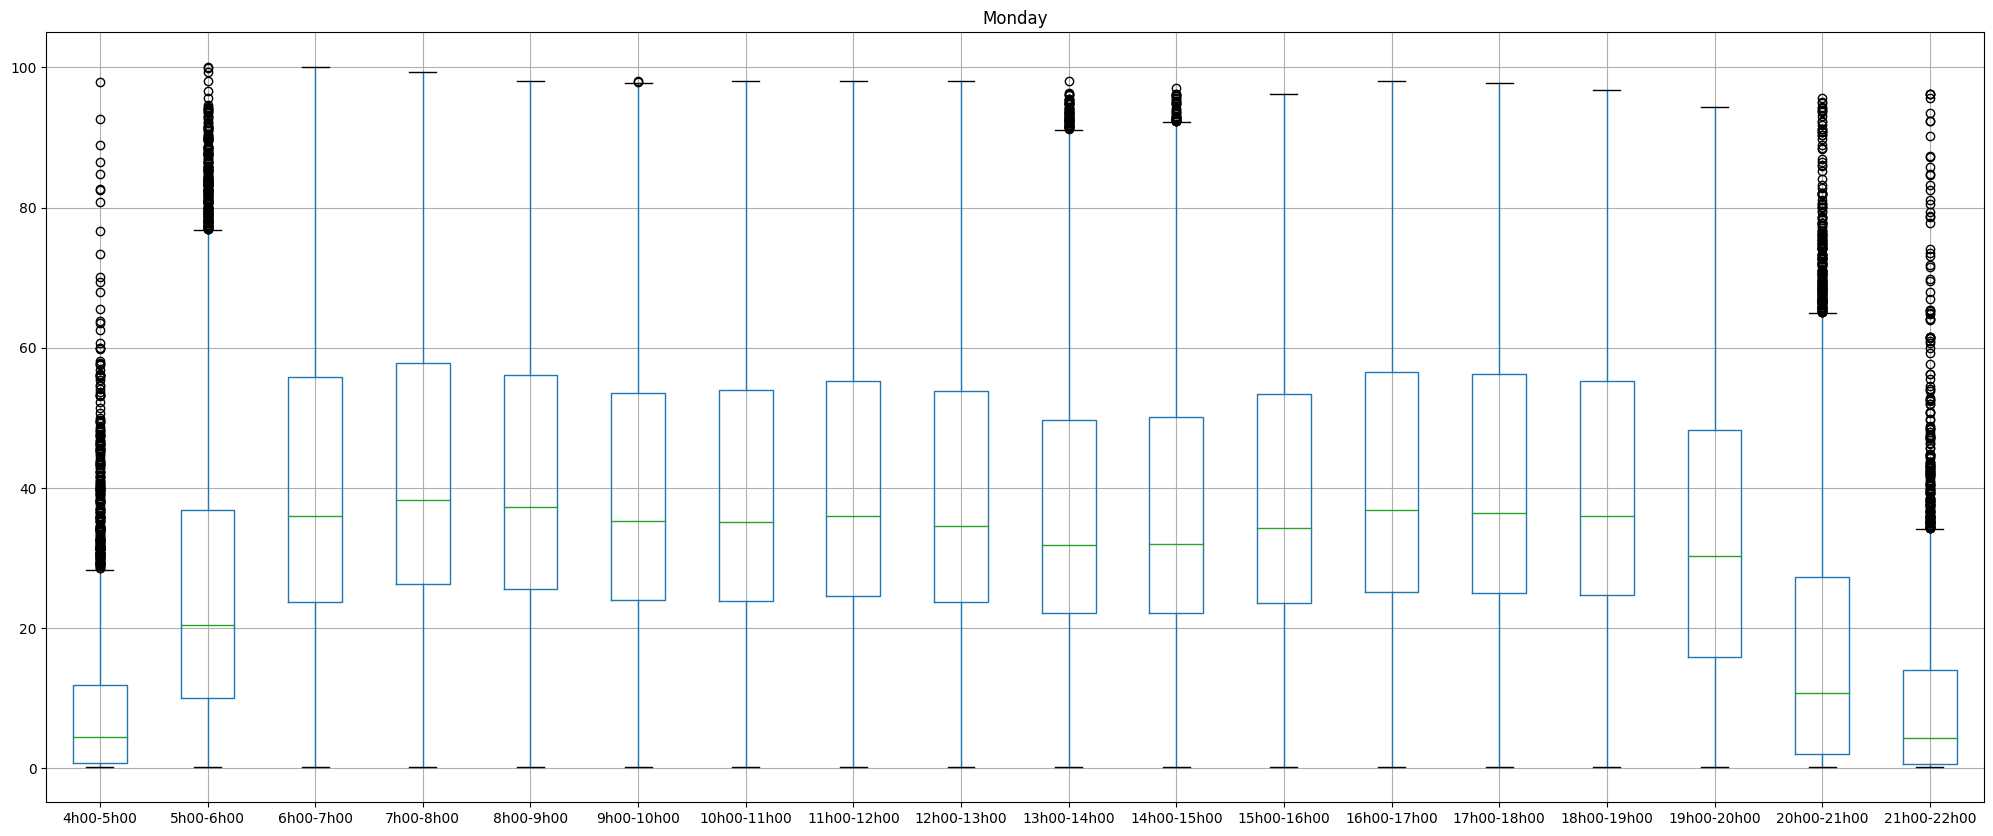

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

pd.read_excel("../stats/ID_statistics_weekday_ratio.xlsx", sheet_name=weekday_list[0]).iloc[:,1:].boxplot(figsize=(25,10)).set_title(f'{weekday_list[0]}')

In [35]:
pd.read_excel("../stats/ID_statistics_weekday_ratio.xlsx", sheet_name=weekday_list[1]).iloc[:,1:].describe()

,4h00-5h00,5h00-6h00,6h00-7h00,7h00-8h00,8h00-9h00,9h00-10h00,10h00-11h00,11h00-12h00,12h00-13h00,13h00-14h00,14h00-15h00,15h00-16h00,16h00-17h00,17h00-18h00,18h00-19h00,19h00-20h00,20h00-21h00,21h00-22h00
count,3324.000000,9145.000000,9388.000000,9409.000000,9447.000000,9429.000000,9426.000000,9478.000000,9432.000000,9424.000000,9432.000000,9415.000000,9453.000000,9465.000000,9440.000000,9261.000000,7520.000000,3872.000000
mean,9.111956,25.867873,40.568429,43.016643,42.256360,40.423163,40.654005,41.434719,40.720148,37.963237,38.306124,40.500633,42.530370,42.459855,41.548664,35.135521,18.905952,9.713600
std,12.030353,19.922231,22.717189,22.978427,22.854108,22.420903,22.427068,22.989877,22.744588,21.774850,21.953601,22.578051,23.206507,23.323806,22.911552,23.336806,20.083260,13.566852
min,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256,0.160256
25%,0.641026,10.256410,24.198718,26.602564,26.121795,24.839744,24.719551,25.000000,24.358974,22.756410,23.076923,24.519231,26.121795,25.961538,25.480769,16.506410,2.403846,0.480769
50%,4.967949,20.673077,36.217949,38.782051,37.980769,36.057692,36.217949,37.019231,35.897436,33.012821,33.493590,35.576923,38.141026,37.980769,37.179487,31.570513,11.858974,3.846154
75%,12.660256,36.698718,55.929487,58.493590,57.051282,54.487179,55.448718,56.730769,55.769231,51.442308,52.083333,55.288462,58.333333,58.493590,56.891026,50.641026,29.647436,14.262821
max,98.237179,99.358974,97.916667,99.198718,99.679487,100.000000,99.839744,99.679487,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.679487,99.679487,100.000000,100.000000


In [46]:
for wd in weekday_list:
    print(wd)
    print(pd.read_excel("../stats/ID_statistics_weekday_ratio.xlsx", sheet_name=wd).iloc[:,1:].describe())

Monday
         4h00-5h00    5h00-6h00    6h00-7h00    7h00-8h00    8h00-9h00   
count  3361.000000  9150.000000  9397.000000  9407.000000  9432.000000  \
mean      8.853440    25.751489    40.420957    42.662124    41.425500   
std      11.862665    19.957351    22.992754    22.970053    22.402287   
min       0.160256     0.160256     0.160256     0.160256     0.160256   
25%       0.801282    10.096154    23.717949    26.282051    25.641026   
50%       4.487179    20.512821    36.057692    38.301282    37.339744   
75%      11.858974    36.818910    55.769231    57.852564    56.089744   
max      97.916667   100.000000   100.000000    99.358974    98.076923   

        9h00-10h00  10h00-11h00  11h00-12h00  12h00-13h00  13h00-14h00   
count  9442.000000  9430.000000  9478.000000  9460.000000  9408.000000  \
mean     39.408973    39.548937    40.372543    39.397006    36.797601   
std      21.976724    21.950716    22.467987    22.272896    21.046894   
min       0.160256     0.16025

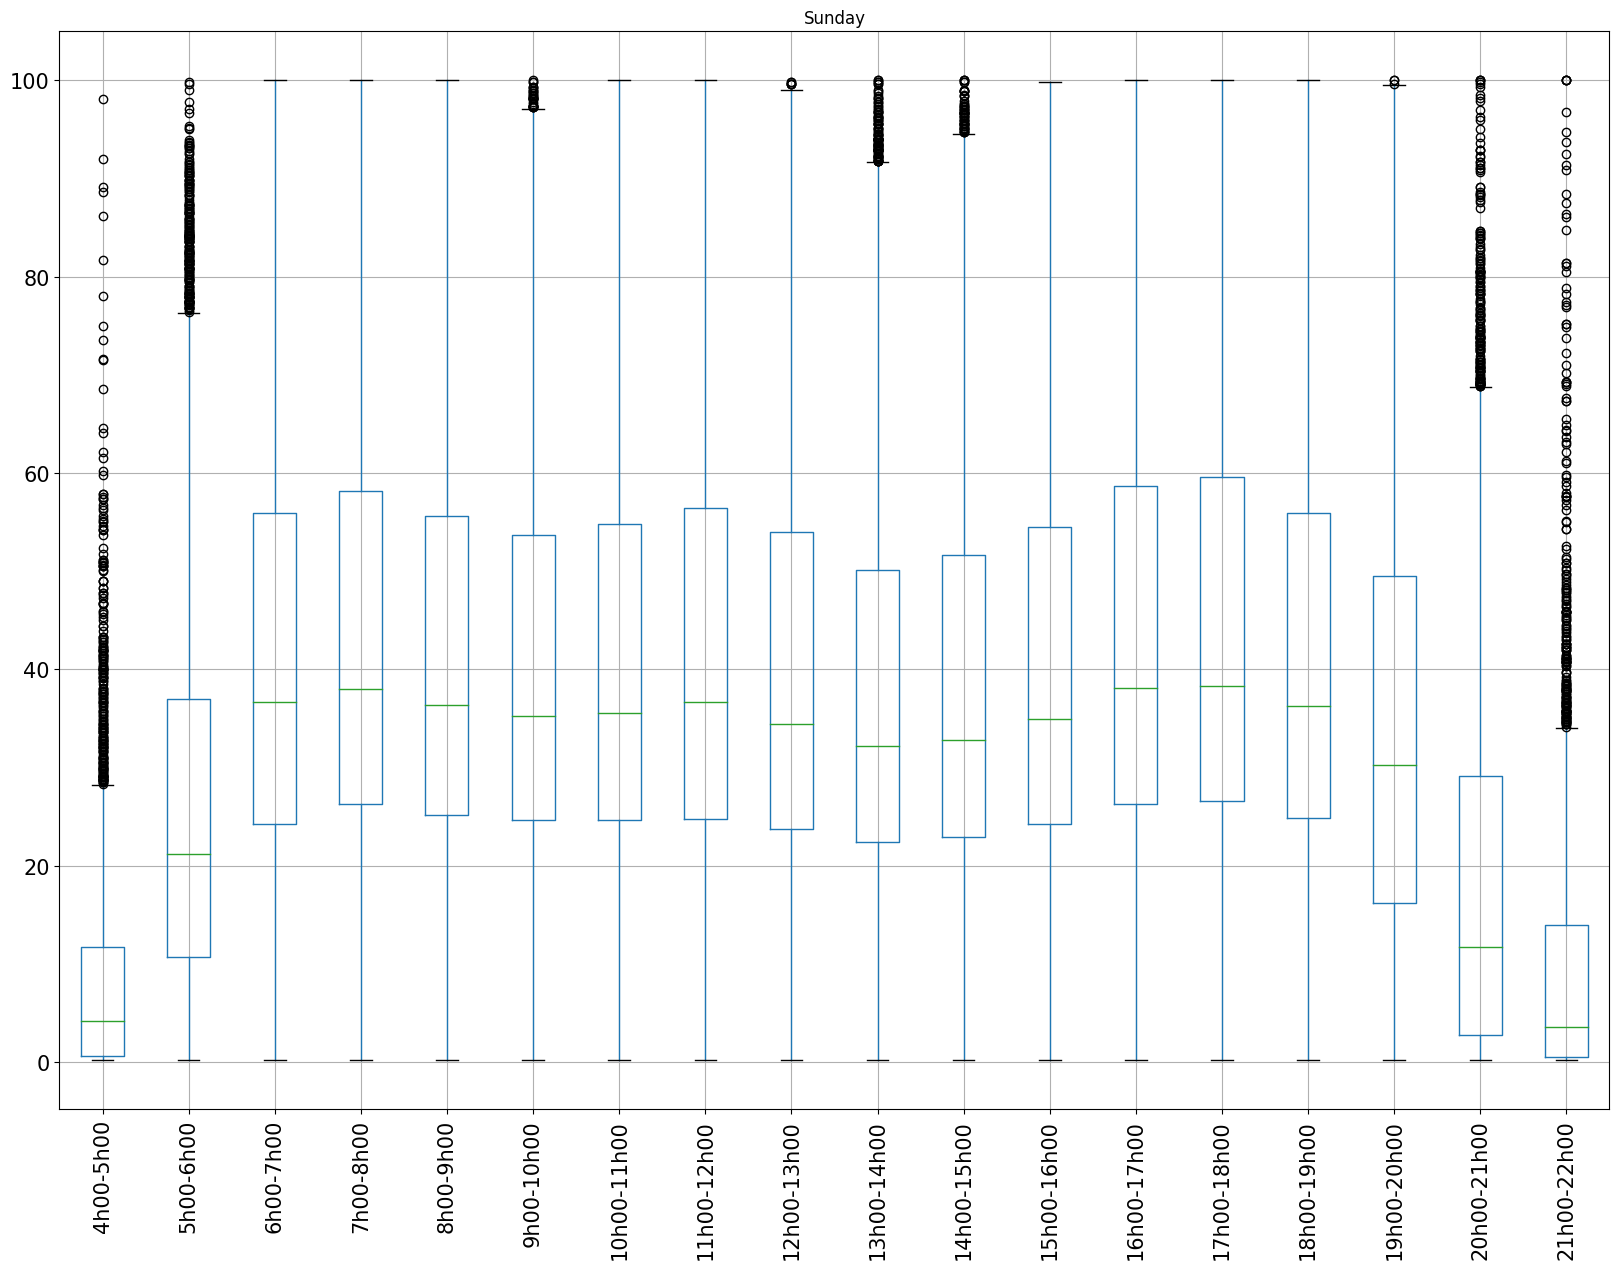

In [36]:
for wd in weekday_list:
    plt.close()
    pd.read_excel("../stats/ID_statistics_weekday_ratio.xlsx", sheet_name=wd).iloc[:,1:].boxplot(figsize=(20,14), 
                                                                                                 rot=90, fontsize=15).set_title(f'{wd}').get_figure().savefig(
                                                                                                f'../stats/ratio/{wd}.png', bbox_inches='tight')


#### Descriptive statistics month of year every hours from 04h00 to 22h00

In [43]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
month_dict = {k:month_list[k-1] for k in range(1,len(month_list)+1)}

In [44]:
df = df.with_columns(
    pl.col('date').dt.month().apply(lambda x: month_dict[x]).alias('month')
)

In [45]:
for i in tqdm(range(1,13)):
    if i == 1:
        write_mode = 'w'
    else:
        write_mode = 'a'
    with pd.ExcelWriter("./out_stats_31May2023_rain/ID_statistics_monthly_rain.xlsx",  mode=write_mode, engine="openpyxl") as writer:
        tmp = df.filter(
                    pl.col('month') == month_list[i-1]
                ).filter(
                    pl.col('hour_id') == 1
                ).groupby('kml_segment_id').agg(pl.col('rain').mean().alias('ave_rain')).sort(by='kml_segment_id')
        tmp = tmp.to_pandas().merge(right=df['kml_segment_id'].unique().to_pandas(), how='right').sort_values(by='kml_segment_id')   
        tmp = tmp.rename(columns={'ave_rain':f"{1+3}h00-{1+4}h00"})
        
        for j in range(2,19):
            TMP2 = df.filter(
                    pl.col('month') == month_list[i-1]
                ).filter(
                    pl.col('hour_id') == j
                ).groupby('kml_segment_id').agg(pl.col('rain').mean().alias('ave_rain')).sort(by='kml_segment_id')
            TMP2 = TMP2.to_pandas().merge(right=df['kml_segment_id'].unique().to_pandas(), how='right').sort_values(by='kml_segment_id')   
            assert len(tmp) == len(TMP2)
            tmp = tmp.merge(TMP2.rename(columns={'ave_rain':f"{j+3}h00-{j+4}h00"}), how='left',  on='kml_segment_id') 
        
        tmp.to_excel(writer, sheet_name=month_dict[i], index=False)
    


  0%|          | 0/12 [00:00<?, ?it/s]

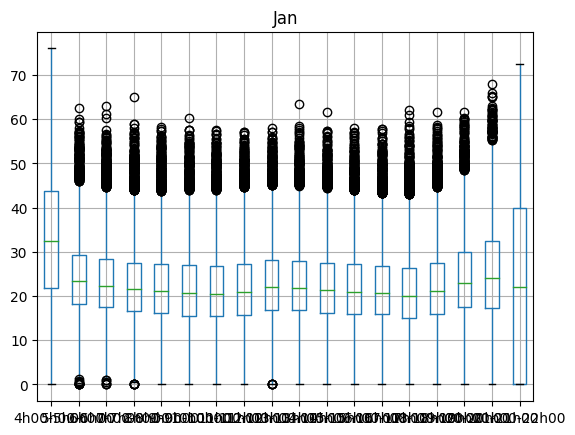

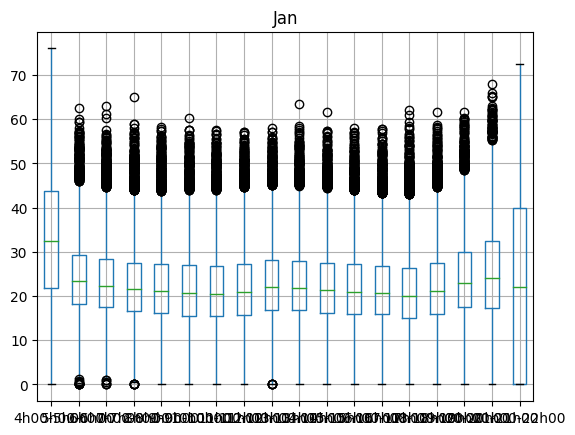

In [40]:
iiiiid = 0
plt.clf()
pd.read_excel("./out_stats_31May2023_rain/ID_statistics_monthly_rain.xlsx", sheet_name=month_list[iiiiid]).iloc[:,1:].boxplot(figsize=(25,10)).set_title(f'{month_list[iiiiid]}').get_figure()

In [41]:
pd.read_excel("../stats/ID_statistics_monthly_speed.xlsx", sheet_name=month_list[iiiiid]).iloc[:,1:].describe()


,4h00-5h00,5h00-6h00,6h00-7h00,7h00-8h00,8h00-9h00,9h00-10h00,10h00-11h00,11h00-12h00,12h00-13h00,13h00-14h00,14h00-15h00,15h00-16h00,16h00-17h00,17h00-18h00,18h00-19h00,19h00-20h00,20h00-21h00,21h00-22h00
count,1729.000000,8386.000000,8584.000000,8618.000000,8623.000000,8617.000000,8619.000000,8625.000000,8625.000000,8617.000000,8619.000000,8622.000000,8611.000000,8623.000000,8627.000000,8296.000000,5073.000000,953.000000
mean,32.875615,24.258405,23.536602,22.790692,22.502028,22.029488,21.977891,22.325013,23.214092,23.039027,22.504215,22.329556,22.096498,21.517660,22.514839,24.301342,25.079414,22.547768
std,15.550948,8.792179,8.720297,8.808306,8.850596,8.948408,9.020074,9.004263,8.856392,8.782914,8.837457,8.793168,8.697041,8.894282,9.038710,9.607347,12.316165,19.808476
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.723784,18.109016,17.452895,16.565803,16.132129,15.535294,15.458379,15.798774,16.907719,16.749018,16.154581,16.035931,15.931825,15.143237,16.046246,17.506366,17.280909,0.124183
50%,32.500000,23.340712,22.362052,21.492582,21.166667,20.614923,20.510847,20.854768,21.994322,21.835616,21.282348,20.992707,20.707195,19.976827,21.071912,23.035192,24.080588,22.000000
75%,43.857143,29.284399,28.329427,27.497035,27.195197,26.921739,26.897477,27.333333,28.153467,28.025800,27.461760,27.181533,26.827923,26.311402,27.482051,29.859255,32.500000,40.000000
max,76.000000,62.500000,62.898000,65.000000,58.129853,60.196667,57.548193,57.173260,57.951325,63.363333,61.670000,57.906000,57.896459,62.000000,61.563056,61.528750,68.000000,72.500000


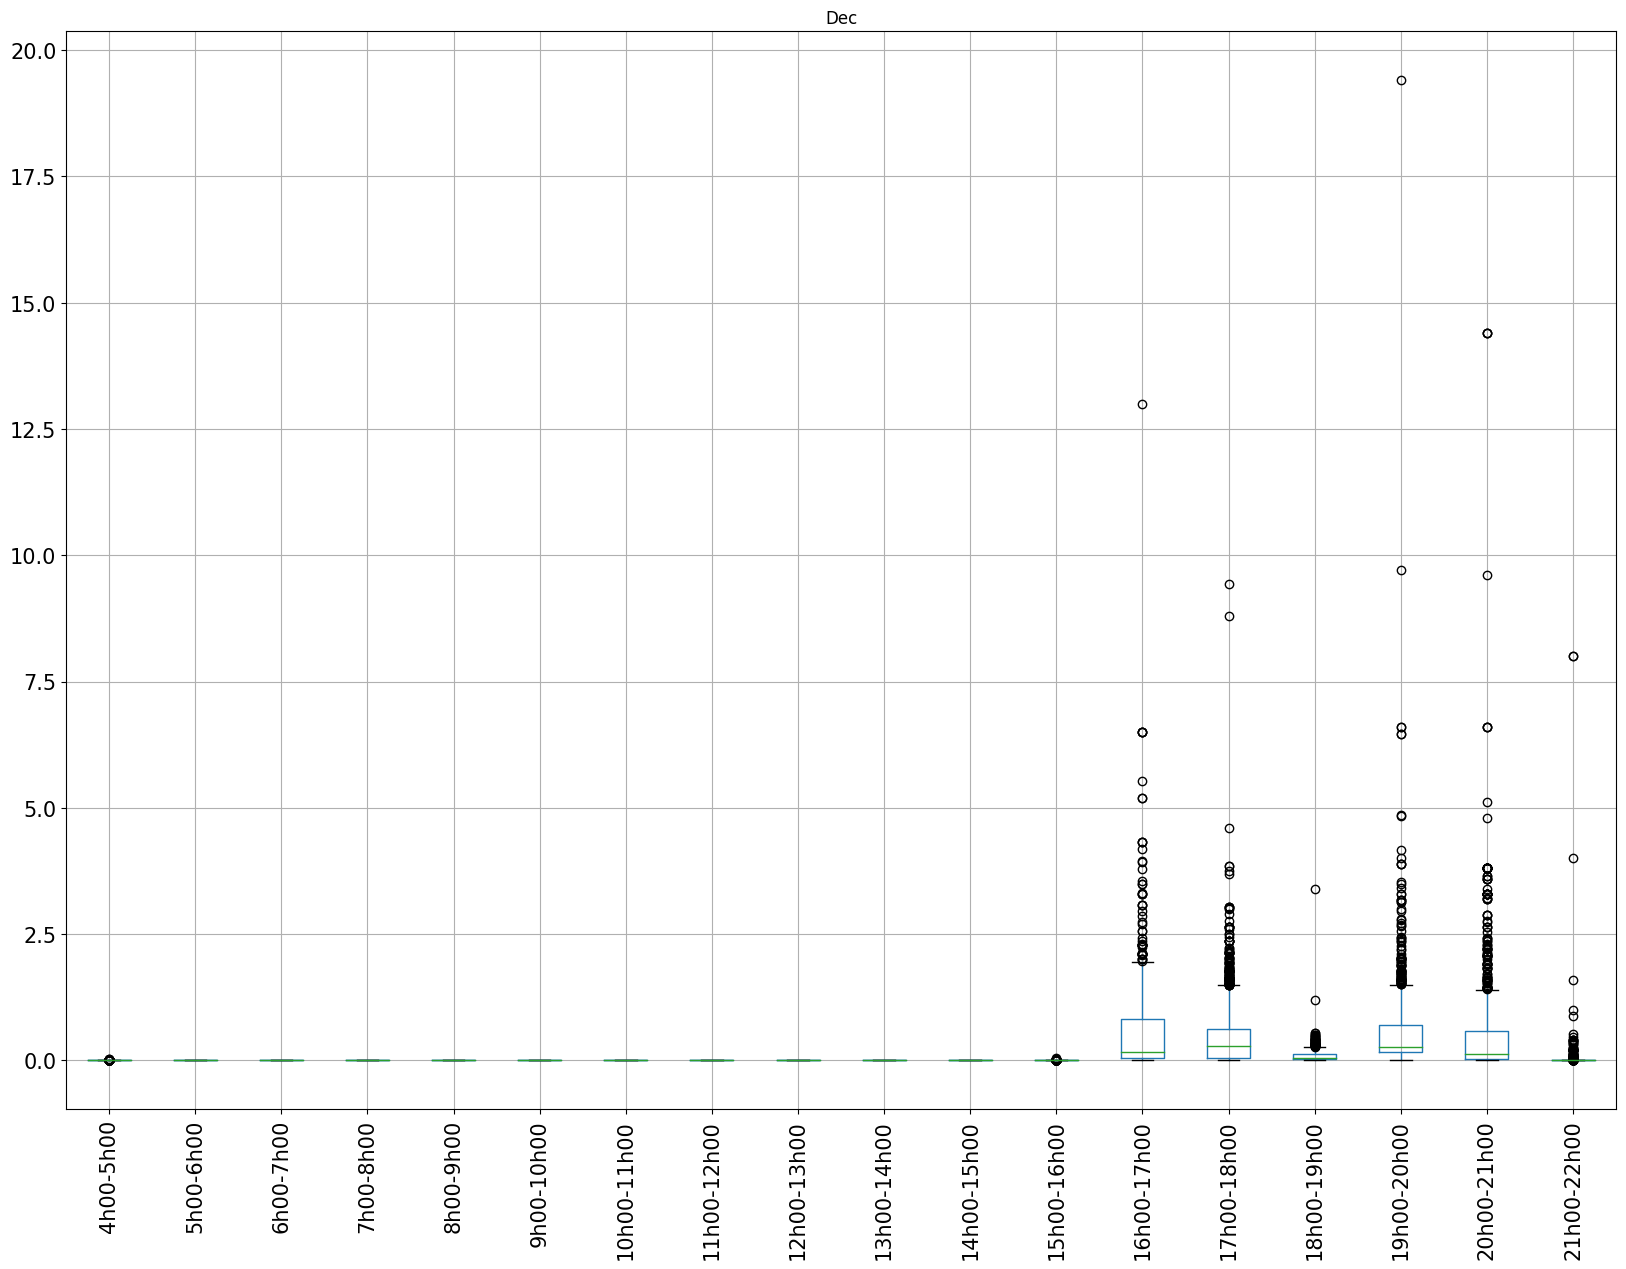

In [46]:
for my in month_list:
    plt.close()
    pd.read_excel("./out_stats_31May2023_rain/ID_statistics_monthly_rain.xlsx", sheet_name=my).iloc[:,1:].boxplot(figsize=(20,14), 
                                                                                                 rot=90, fontsize=15).set_title(f'{my}').get_figure().savefig(
                                                                                                f'./out_stats_31May2023_rain/months/{my}.png', bbox_inches='tight')


In [ ]:
speed